This notebook shows how to train a random forests classification model with composition data to predict the type of compounds from the three classes quasicrystal (QC), approximant crystal (AC), and others (OTHERS) and perform a virtual screening by using it.

We used the same procedure to train our classification model in our [previous](https://onlinelibrary.wiley.com/doi/10.1002/adma.202102507) study. You can download the pre-trained model from [here](https://github.com/yoshida-lab/XenonPy/releases/download/v0.6.5/best_QC_AC_classification_model.pkl.z)

First, let's load some common packages for this task.
We use XenonPy to calculate the descriptors from the composition of compounds. 
To ensure everything goes smoothly. Please confirm that the version of XenonPy is higher than v0.6.5.
If you have not installed XenonPy, please follow the official [installation guide](https://xenonpy.readthedocs.io/en/latest/installation.html#using-conda-and-pip).

In [1]:
%run tools.ipynb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from pathlib import Path
from matplotlib import pyplot as plt

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# version should greater than 0.4.1

import xenonpy as xe
xe.__version__

'0.6.5'

### Model training

We will train the model with the best hyperparameters from our previous paper. The training data of `QC` and `AC` are collected from literature, the 10,090 `OTHERS` data are randomly selected from the [Materials Project database](https://materialsproject.org/) and laboratory data on failed quasicrystal syntheses. 

#### load training data

In [3]:
training_data = pd.read_csv(
    'training_data.csv',
    index_col=0,
    converters={'composition': eval, 'elements': eval},
)

training_data
training_data.label.unique()

,composition,elements,label,for_test
Ag 52.0 Al 33.0 Ce 15.0,"{'Ag': 52.0, 'Al': 33.0, 'Ce': 15.0}","(Ag, Al, Ce)",OTHERS,False
mp-1077980,"{'Sr': 1.0, 'Ag': 4.0, 'Sb': 2.0}","(Ag, Sb, Sr)",OTHERS,False
mp-30079,"{'Li': 1.0, 'Mg': 2.0, 'Ge': 1.0}","(Ge, Li, Mg)",OTHERS,False
mvc-2967,"{'Ba': 2.0, 'Tl': 1.0, 'Fe': 2.0, 'O': 7.0}","(Ba, Fe, O, Tl)",OTHERS,False
mp-1202279,"{'K': 18.0, 'Ho': 18.0, 'F': 72.0}","(F, Ho, K)",OTHERS,False
...,...,...,...,...
mp-5960,"{'O': 12.0, 'Ca': 6.0, 'U': 2.0}","(Ca, O, U)",OTHERS,True
mp-1198997,"{'C': 16.0, 'S': 8.0, 'N': 8.0, 'O': 8.0, 'F':...","(C, F, N, O, S)",OTHERS,True
mp-1219422,"{'Sc': 28.0, 'As': 12.0}","(As, Sc)",OTHERS,True
mp-757593,"{'Li': 4.0, 'Co': 5.0, 'Sb': 1.0, 'O': 12.0}","(Co, Li, O, Sb)",OTHERS,True


array(['OTHERS', 'QC', 'AC'], dtype=object)

As we described above, our data has three labels, `QC`, `AC`, and `OTHERS`.

#### calculate compositional descriptors

We use `xenonpy.descriptor.Compositions` to calculate the descriptors. As we described in [our paper](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202102507), we only use `weighted average`, `weighted variance`, `max-pooling`, and `min-pooling` in this task.

In [4]:
from xenonpy.descriptor import Compositions

# # use specific featurizers
featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']

compositions = Compositions(featurizers=featurizers, n_jobs=20)
compositions.fit_transform?

Signature: compositions.fit_transform(X, y=None, **fit_params)
Docstring:
Fit to data, then transform it.

Fits transformer to `X` and `y` with optional parameters `fit_params`
and returns a transformed version of `X`.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Input samples.

y :  array-like of shape (n_samples,) or (n_samples, n_outputs),                 default=None
    Target values (None for unsupervised transformations).

**fit_params : dict
    Additional fit parameters.

Returns
-------
X_new : ndarray array of shape (n_samples, n_features_new)
    Transformed array.
File:      ~/mambaforge/envs/xepy38/lib/python3.8/site-packages/sklearn/base.py
Type:      method


o use this calculator, users only need to feed a iterable object containing composition information of compounds to the cal.transform or cal.fit_transform method of cal. The input type can be `pymatgen.core.Compositon`, or dicts which have the structure like {'H': 2, 'O': 1}.

In [5]:
%%time

desc = compositions.fit_transform(training_data.composition)

desc

CPU times: user 2.9 s, sys: 512 ms, total: 3.41 s
Wall time: 5.78 s


,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
Ag 52.0 Al 33.0 Ce 15.0,37.430000,149.220000,238.170000,11.806000,86.012772,2751.250000,80.380000,870.920000,145.930000,132.590000,...,1.0,3.0,0.205,11.00000,184.0,225.0,236.0,314.8,2100.000000,6.780
mp-1077980,46.857143,158.428571,238.714286,15.957143,108.944686,2201.857143,79.497211,800.285714,150.428571,139.571429,...,1.0,5.0,0.205,24.00000,206.0,247.0,243.0,314.8,2600.000000,6.600
mp-30079,14.750000,153.000000,233.500000,13.675000,32.045000,1736.787500,49.384485,758.250000,132.500000,133.000000,...,1.0,2.0,0.322,60.00000,173.0,212.0,243.0,245.1,4602.000000,5.840
mvc-2967,25.083333,157.534162,206.416667,17.283333,58.559750,1018.944167,77.911857,1066.825000,110.083333,100.750000,...,2.0,2.0,0.128,0.02658,152.0,150.0,182.0,291.2,317.500000,0.802
mp-1202279,20.333333,158.349076,193.166667,22.066667,46.670374,725.840000,38.382626,1038.466667,103.833333,103.000000,...,1.0,2.0,0.164,0.02770,147.0,146.0,171.0,336.4,2000.000000,0.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-5960,20.000000,160.620852,211.900000,18.620000,45.425691,983.014000,60.763625,928.149258,112.000000,106.100000,...,2.0,2.0,0.115,0.02658,152.0,150.0,182.0,339.5,317.500000,0.802
mp-1198997,8.666667,113.537506,184.500000,12.416667,17.514401,1861.737333,42.328311,48.066667,74.166667,75.166667,...,2.0,2.0,0.711,0.02583,147.0,146.0,171.0,336.4,317.500000,0.557
mp-1219422,24.600000,155.100000,253.400000,14.430000,53.945614,2435.600000,46.500000,1177.000000,154.700000,139.900000,...,2.0,4.0,0.328,16.00000,185.0,188.0,236.0,329.5,3638.678266,4.310
mp-757593,13.363636,143.564411,194.909091,12.377273,28.916999,1053.540000,86.330568,393.154545,96.954545,90.136364,...,1.0,2.0,0.205,0.02658,152.0,150.0,182.0,245.1,317.500000,0.802


#### Train the model

In our [previous paper](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202102507), we applied a grid searching to find the best hyperparameters of the rrandom forest classifier as below. To simple this demonstration, we use the best hyperparameters found previously to train our model.

```python
param_grid = dict(
    random_state=[0],
    max_depth=[5, 10, 15, 20, 25],
    n_estimators=[50, 100, 200, 300],
    max_features=['sqrt', 'log2', None],
    bootstrap=[True, False],
    criterion=["gini", "entropy"]
)
```

Best parameters:
```python
hyperparams = dict(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)
```

In order to evaluate the model performance after training our model, we have to leave some data for testing. In short, we have to split our data into `train` and `test` dataset. We provided our data with the label `for_test` to denote which data we had used for the test in our model training process in the previous work.
You can use this flag to reproduce our work, but here, we'd like to show a standard procedure of how to train the model.

There are lots of choices to do this work, here we use the `xenonpy.datatools.Splitter` class.

In [6]:
from xenonpy.datatools import Splitter

Splitter?

Init signature:
Splitter(
    size: int,
    *,
    test_size: Union[float, int] = 0.2,
    k_fold: Union[int, Iterable, NoneType] = None,
    random_state: Union[int, NoneType] = None,
    shuffle: bool = True,
)
Docstring:      Data splitter for train and test
Init docstring:
Parameters
----------
size
    Total sample size.
    All data must have same length of their first dim,
test_size
    If float, should be between ``0.0`` and ``1.0`` and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. Can be ``0`` if cv is ``None``.
    In this case, :meth:`~Splitter.cv` will yield a tuple only contains ``training`` and ``validation``
    on each step. By default, the value is set to 0.2.
k_fold
    Number of k-folds.
    If ``int``, Must be at least 2.
    If ``Iterable``, it should provide label for each element which will be used for group cv.
    In this case, the input of :meth:`~Splitter.cv` must be a :c

In [7]:
splitter = Splitter(size=desc.shape[0], random_state=0, test_size=0.2)
splitter

Splitter(random_state=0, size=10248)

In [8]:
x_train, x_test, y_train, y_test = splitter.split(desc, training_data.label)

x_train.shape
y_train.shape
x_test.shape
y_test.shape

(8198, 232)

(8198,)

(2050, 232)

(2050,)

Use [scikit-learn random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier) to train the model

In [9]:
from sklearn.ensemble import RandomForestClassifier

# prepare the random forest class
rfc = RandomForestClassifier(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)

rfc

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

In [10]:
# train the model with training data
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

predict the label of train and test data

In [11]:
y_pred, y_true = rfc.predict(x_test), y_test
y_pred_fit, y_true_fit = rfc.predict(x_train), y_train

#### confusion matrix

Confusion matrix is a very popular measure used while solving classification problems. You can [here](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) for some details.

In [12]:
# import a library for evaluating the model performance based on confusion matrix
from sklearn.metrics import confusion_matrix

labels = ['OTHERS', 'QC', 'AC']
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_fit = confusion_matrix(y_true_fit, y_pred_fit, labels=labels)

print('Testing CM:')
cm

print('\nTraining CM:')
cm_fit

Testing CM:


array([[2010,    1,    2],
       [   4,   12,    4],
       [   4,    4,    9]])


Training CM:


array([[8076,    0,    1],
       [   1,   59,    0],
       [   0,    0,   61]])

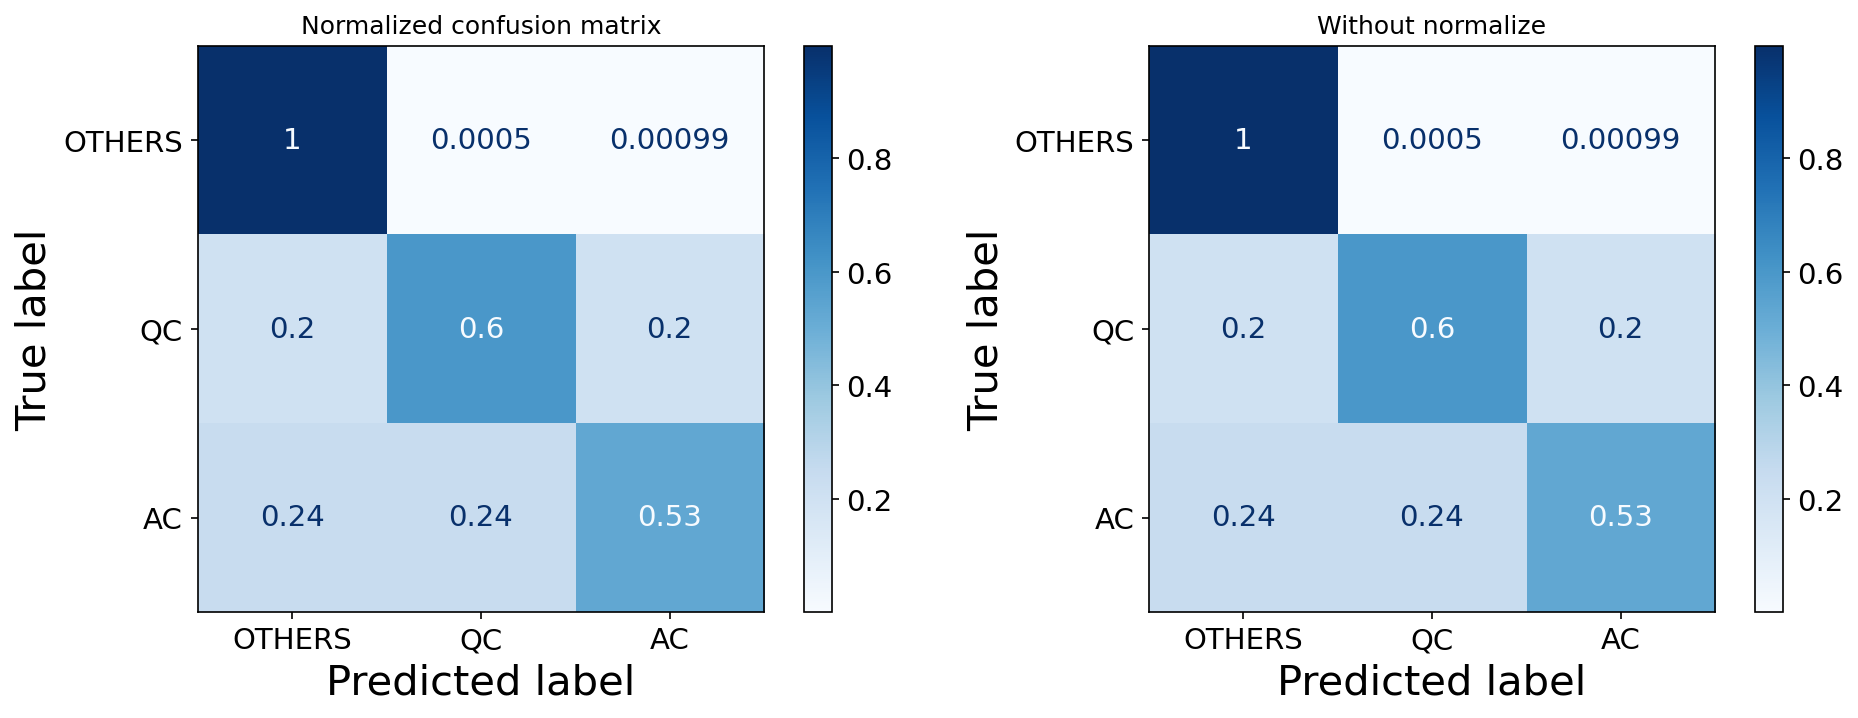

In [13]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
cm = cm / cm.sum(axis=1, keepdims=True)
cmd = ConfusionMatrixDisplay(cm, labels)
_ = cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax1)
_ = ax1.set_title("Normalized confusion matrix")

cmd = ConfusionMatrixDisplay(cm, labels)
_ = cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax2)
_ = ax2.set_title("Without normalize")

Finally, save our model for further using.

In [14]:
import joblib

Path('pre_trained_model/').mkdir(exist_ok=True, parents=True)
joblib.dump(rfc, 'pre_trained_model/classification_model_with_taining_data.pkl.z')

['pre_trained_model/classification_model_with_taining_data.pkl.z']

### Virtual screening

We can perform virtual screening for **any compositions** by using our pre-trained model. However, in our study, we focus on the ternary systems. The following parts will demonstrate how to perform virtual screening and visualization of the ternary system in a phase diagram.

For convenience, we choose a system from the test dataset which is observed and predicted to have QC compounds.

In [15]:
test_data = training_data.loc[x_test.index].assign(prediction=y_pred).drop(columns=['composition', 'for_test'])

test_data[(test_data.label == 'QC') & (test_data.prediction == 'QC')]

,elements,label,prediction
Cd 65 Mg 20 Yb 15,"(Cd, Mg, Yb)",QC,QC
Zn 75 Sc 15 Ni 10,"(Ni, Sc, Zn)",QC,QC
Zn 75 Sc 15 Au 10,"(Au, Sc, Zn)",QC,QC
Al 65 Cu 20 Os 15,"(Al, Cu, Os)",QC,QC
Zn 74 Mg 15 Ho 11,"(Ho, Mg, Zn)",QC,QC
Al 70 Pd 21 Tc 9,"(Al, Pd, Tc)",QC,QC
Zn 55 Mg 40 Nd 5,"(Mg, Nd, Zn)",QC,QC
Zn 58 Mg 40 Ho 2,"(Ho, Mg, Zn)",QC,QC
Cd 65 Mg 20 Ca 15,"(Ca, Cd, Mg)",QC,QC
Zn 75 Sc 15 Pd 10,"(Pd, Sc, Zn)",QC,QC


Let's use Al-Cu-Os system.

#### Virtual composition

First, let's generate virtual compositons to cover all compostions like Al𝑎Cu𝑏Os𝑐, where 𝑎, 𝑏, 𝑐 are the ratios. We have prepared function make_virtual_compounds to simplify this step.

In [16]:
make_virtual_compounds?

Signature:
make_virtual_compounds(
    *elements,
    interval=0.5,
    pen_size=10,
    reorder_elements=True,
    max_proportion=100,
    **element_ratio,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_485723/3766468394.py
Type:      function


In [17]:
target = ('Al', 'Cu', 'Os')

v_comps = make_virtual_compounds(*target, reorder_elements=False, interval=0.25, max_proportion=100)
v_comps

,composition,elements
0,"{'Al': 0.25, 'Cu': 99.75, 'Os': 0.0}","(Al, Cu, Os)"
1,"{'Al': 0.5, 'Cu': 99.5, 'Os': 0.0}","(Al, Cu, Os)"
2,"{'Al': 0.75, 'Cu': 99.25, 'Os': 0.0}","(Al, Cu, Os)"
3,"{'Al': 1.0, 'Cu': 99.0, 'Os': 0.0}","(Al, Cu, Os)"
4,"{'Al': 1.25, 'Cu': 98.75, 'Os': 0.0}","(Al, Cu, Os)"
...,...,...
80593,"{'Al': 0.0, 'Cu': 0.5, 'Os': 99.5}","(Al, Cu, Os)"
80594,"{'Al': 0.25, 'Cu': 0.25, 'Os': 99.5}","(Al, Cu, Os)"
80595,"{'Al': 0.5, 'Cu': 0.0, 'Os': 99.5}","(Al, Cu, Os)"
80596,"{'Al': 0.0, 'Cu': 0.25, 'Os': 99.75}","(Al, Cu, Os)"


#### Calculate descriptors and predict classed using pre-trained model

In [18]:
%%time

v_desc = compositions.fit_transform(v_comps)
v_desc.shape

CPU times: user 18.6 s, sys: 1.12 s, total: 19.7 s
Wall time: 19.4 s


(80598, 232)

In [19]:
pred_proba = pd.DataFrame(rfc.predict_proba(v_desc), columns=rfc.classes_)
pred_labels = pred_proba.assign(pred_label=rfc.predict(v_desc))
pred_results = pd.concat([v_comps, pred_labels], axis=1)
pred_results

,composition,elements,AC,OTHERS,QC,pred_label
0,"{'Al': 0.25, 'Cu': 99.75, 'Os': 0.0}","(Al, Cu, Os)",0.090,0.850,0.060,OTHERS
1,"{'Al': 0.5, 'Cu': 99.5, 'Os': 0.0}","(Al, Cu, Os)",0.090,0.850,0.060,OTHERS
2,"{'Al': 0.75, 'Cu': 99.25, 'Os': 0.0}","(Al, Cu, Os)",0.090,0.850,0.060,OTHERS
3,"{'Al': 1.0, 'Cu': 99.0, 'Os': 0.0}","(Al, Cu, Os)",0.090,0.850,0.060,OTHERS
4,"{'Al': 1.25, 'Cu': 98.75, 'Os': 0.0}","(Al, Cu, Os)",0.090,0.850,0.060,OTHERS
...,...,...,...,...,...,...
80593,"{'Al': 0.0, 'Cu': 0.5, 'Os': 99.5}","(Al, Cu, Os)",0.005,0.930,0.065,OTHERS
80594,"{'Al': 0.25, 'Cu': 0.25, 'Os': 99.5}","(Al, Cu, Os)",0.005,0.930,0.065,OTHERS
80595,"{'Al': 0.5, 'Cu': 0.0, 'Os': 99.5}","(Al, Cu, Os)",0.010,0.925,0.065,OTHERS
80596,"{'Al': 0.0, 'Cu': 0.25, 'Os': 99.75}","(Al, Cu, Os)",0.005,0.925,0.070,OTHERS


#### Draw phase diagram

The phase diagram is a graphical representation of the physical states of a substance under different conditions. Here, we use a phase diagram to visualize the predicted structure types (`QC`, `AC`, `OTHERS`) of a ternary system.

In [20]:
labels = ['OTHERS', 'QC', 'AC']
k_folds = 10
# cmap = 'coolwarm'
cmap = 'YlGnBu'
n = 1
criteria = 'mae'
# s_color = 'orangered'
# epa_color = 'indigo'
epa_color = 'orangered'
# pe_color = 'deeppink'
pe_color = 'aqua'
# cmap = 'YlGn'

norm = matplotlib.colors.BoundaryNorm(np.linspace(-1.5, 1.5, 4), 3)
fmt = matplotlib.ticker.FuncFormatter(lambda x, _: ['OTHERS', 'AC', 'QC'][norm(x)])

def trans(s):
    if s == 'QC': return 1.5
    if s == 'AC': return 0
    if s == 'OTHERS': return -1.5

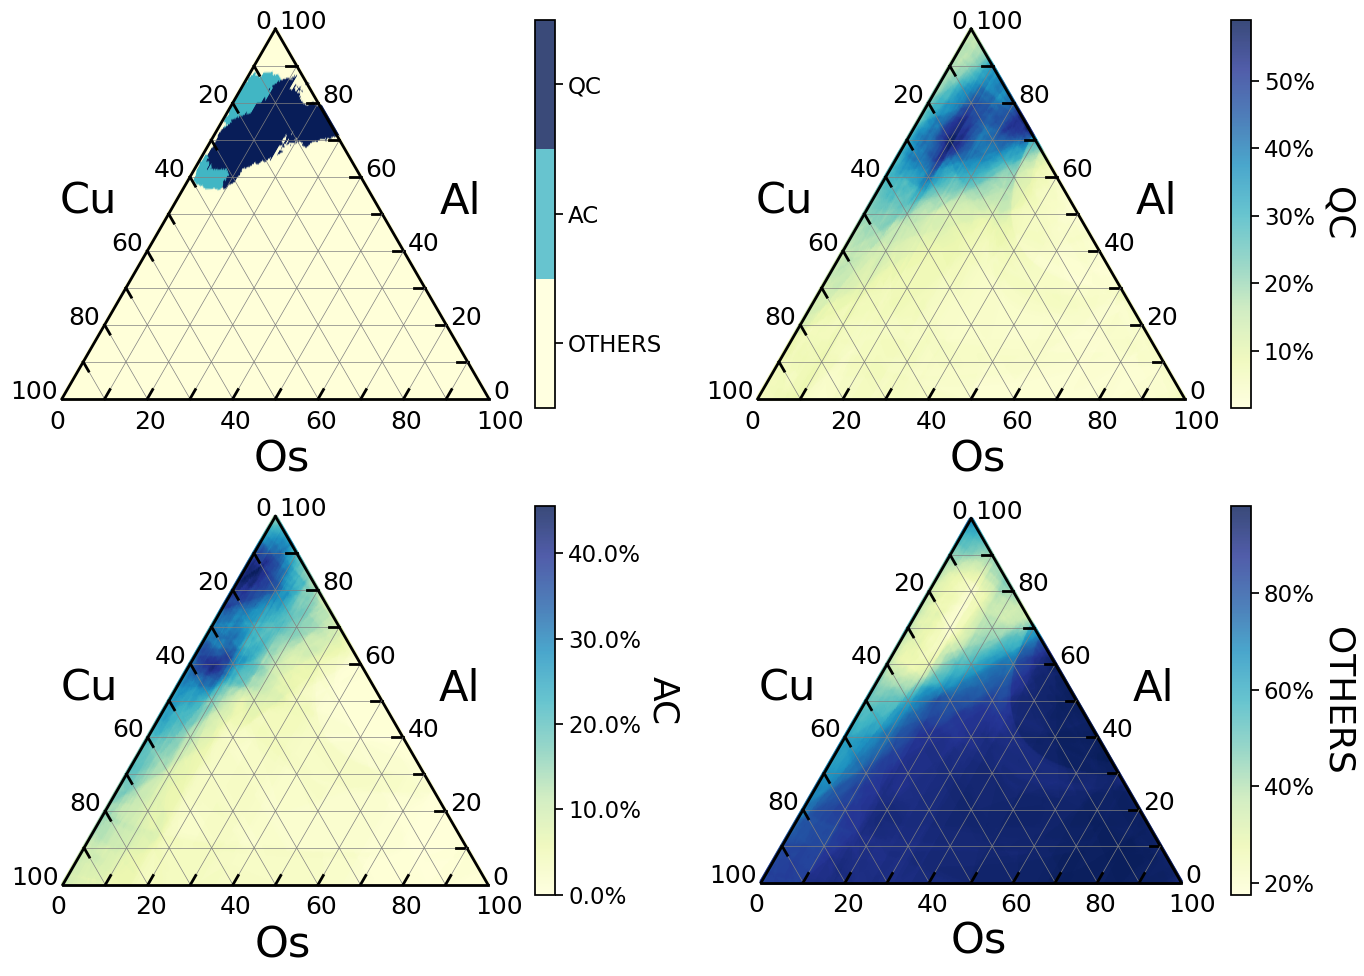

In [21]:
# set overall style
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.labelsize": "large"})

a, b, c = target
tmp = pd.DataFrame([{k: v for k, v in s.items()} for s in pred_results.composition], index=pred_results.index)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# all class
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.pred_label.apply(trans).values,
    a, b, c,
    cbar_kw=dict(
     format=fmt,
     ticks=np.arange(-1, 2)
    ),
    cmap=plt.get_cmap(cmap, 3),
    norm=norm,
    half_size=False,
    reduce_ticks=True,
    ax=ax1
)


# QC
#     sns.set_palette("husl", 4) 
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.QC,
    a, b, c,
    cbarlabel='QC',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax2
)

# AC
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.AC,
    a, b, c,
    cbarlabel='AC',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax3
)

# OTHERS
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.OTHERS,
    a, b, c,
    cbarlabel='OTHERS',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax4
)

# save figure
Path('phase_diagram/').mkdir(exist_ok=True, parents=True)
plt.savefig(f"phase_diagram/{'_'.join(target)}.png", bbox_inches='tight', pad_inches=0, dpi=300)


### Retrain model with all data


We have demonstrated how to train a random forest model and used it to perform a virtual screening for any compositions. Finally, we can retrain our model using the best hyperparameters with all data and save it.

In [22]:
# prepare the random forest class
rfc = RandomForestClassifier(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)

rfc.fit(desc, training_data.label)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

In [24]:
joblib.dump(rfc, 'pre_trained_model/classification_model_with_all_data_training.pkl.z')

['pre_trained_model/classification_model_with_all_data_training.pkl.z']